In [1]:
from datasets import load_dataset

# Load the MBPP dataset
dataset = load_dataset("mbpp", "full") # or "sanitized" if you prefer

# Initialize max length
max_char_length = 0

# Iterate through the 'test' split (MBPP is often a single split, or you might choose 'train')
# and check the 'code' column.
# Common splits are 'train', 'test', 'validation'. MBPP 'full' has 'train', 'test', 'prompt'.
# We'll check all available splits to be safe if the exact structure isn't recalled.
for split in dataset.keys():
    for example in dataset[split]:
        code_snippet = example['code']
        if code_snippet: # Check if the code snippet is not None or empty
            current_length = len(code_snippet)
            if current_length > max_char_length:
                max_char_length = current_length

print(f"The highest character length in the 'code' column is: {max_char_length}")

/Users/krizroycetahimic/miniconda3/envs/pva_sae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The highest character length in the 'code' column is: 1331


In [5]:
import pandas as pd
import json
import os
from pathlib import Path

# View generated datasets
data_dir = Path("data/datasets")

# Load the most recent dataset
parquet_files = sorted(data_dir.glob("*.parquet"))
if parquet_files:
    latest_file = parquet_files[-1]
    print(f"Loading latest dataset: {latest_file.name}")
    
    # Load the dataset
    df = pd.read_parquet(latest_file)
    
    # Display basic info
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Show distribution of results
    if 'test_passed' in df.columns:
        print(f"\nTest results distribution:")
        print(df['test_passed'].value_counts())
    
    print(f"\nDataset preview:")
    # Display as interactive table in Jupyter
    display(df)
    
    # Check column efficiency
    print(f"\nColumn efficiency analysis:")
    print(f"• Essential columns for SAE analysis: {len(df.columns)}")
    print(f"• Total data reduction: Removed ~9 unnecessary columns")
    print(f"• Columns kept: {', '.join(df.columns)}")
    
else:
    print("No parquet files found in data/datasets/")

Loading latest dataset: mbpp_dataset_20250527_203843.parquet

Dataset shape: (3, 3)
Columns: ['task_id', 'generated_code', 'test_passed']

Test results distribution:
test_passed
False    2
True     1
Name: count, dtype: int64

Dataset preview:


,task_id,generated_code,test_passed
0,11,"\ndef remove_Occ(string,char):\n string = string.replace(char,"""")\n return string\n",True
1,12,\ndef sort_matrix(matrix):\n for i in range(len(matrix)):\n matrix[i].sort()\n retu...,False
2,13,\ndef count_common(dictionary):\n count = {}\n for word in dictionary:\n if word in...,False



Column efficiency analysis:
• Essential columns for SAE analysis: 3
• Total data reduction: Removed ~9 unnecessary columns
• Columns kept: task_id, generated_code, test_passed


In [11]:
# Test cognitive_complexity library
# First, let's install it if not already installed
import subprocess
import sys

try:
    import cognitive_complexity
    print("cognitive_complexity is already installed")
except ImportError:
    print("Installing cognitive_complexity...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cognitive_complexity"])
    import cognitive_complexity
    print("Successfully installed cognitive_complexity")

# Now let's test it with MBPP data
import ast
from cognitive_complexity.api import get_cognitive_complexity
from datasets import load_dataset

# Load MBPP dataset
dataset = load_dataset("mbpp", "full")

# Function to calculate complexity for a code snippet
def calculate_code_complexity(code_string):
    """Calculate cognitive complexity for a given code string"""
    try:
        # Parse the code
        tree = ast.parse(code_string)
        
        # Find all function definitions
        complexities = []
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                complexity = get_cognitive_complexity(node)
                complexities.append({
                    'function_name': node.name,
                    'complexity': complexity
                })
        
        # Return max complexity if multiple functions, or 0 if no functions
        if complexities:
            return max(c['complexity'] for c in complexities), complexities
        else:
            return 0, []
            
    except SyntaxError as e:
        return None, f"Syntax error: {e}"
    except Exception as e:
        return None, f"Error: {e}"

# Test with a few examples from MBPP
print("Testing cognitive complexity on MBPP reference solutions:\n")

for i in range(20):  # Test first 5 problems
    record = dataset['test'][i]
    task_id = record['task_id']
    problem_text = record['text']
    reference_code = record['code']
    
    print(f"Task {task_id}: {problem_text[:80]}...")
    print(f"Reference code preview: {reference_code}")
    
    
    complexity, details = calculate_code_complexity(reference_code)
    
    if complexity is not None:
        print(f"Cognitive Complexity: {complexity}")
        if isinstance(details, list):
            for func_info in details:
                print(f"  - Function '{func_info['function_name']}': complexity = {func_info['complexity']}")
    else:
        print(f"Error calculating complexity: {details}")
    
    print("-" * 80 + "\n")

cognitive_complexity is already installed
Testing cognitive complexity on MBPP reference solutions:

Task 11: Write a python function to remove first and last occurrence of a given character...
Reference code preview: def remove_Occ(s,ch): 
    for i in range(len(s)): 
        if (s[i] == ch): 
            s = s[0 : i] + s[i + 1:] 
            break
    for i in range(len(s) - 1,-1,-1):  
        if (s[i] == ch): 
            s = s[0 : i] + s[i + 1:] 
            break
    return s 
Cognitive Complexity: 6
  - Function 'remove_Occ': complexity = 6
--------------------------------------------------------------------------------

Task 12: Write a function to sort a given matrix in ascending order according to the sum ...
Reference code preview: def sort_matrix(M):
    result = sorted(M, key=sum)
    return result
Cognitive Complexity: 0
  - Function 'sort_matrix': complexity = 0
--------------------------------------------------------------------------------

Task 13: Write a function to

Matplotlib is building the font cache; this may take a moment.


Successfully analyzed 500 problems
Errors encountered: 0

Complexity Statistics:
  Min: 0
  Max: 22
  Mean: 2.45
  Median: 1.00


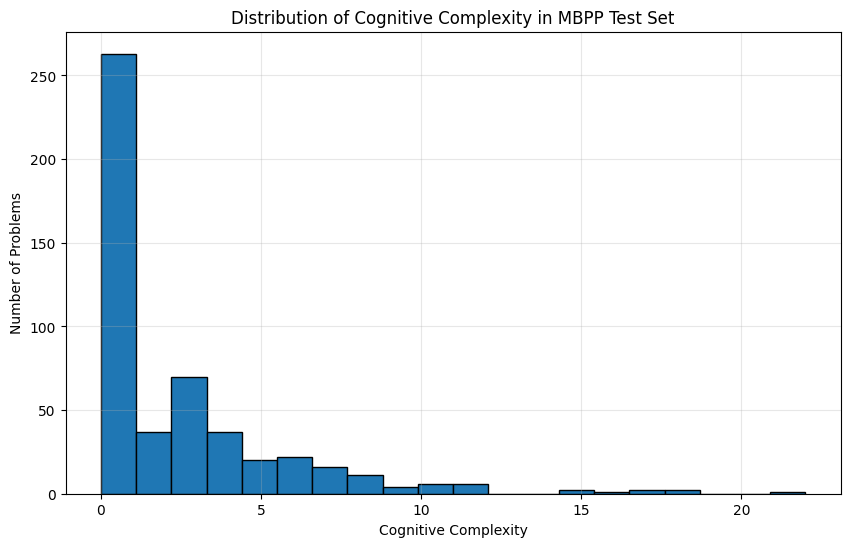


Difficulty Distribution:
  easy: 370 (74.0%)
  hard: 35 (7.0%)
  medium: 95 (19.0%)


In [12]:
# Let's analyze the complexity distribution across all MBPP problems
import matplotlib.pyplot as plt
import numpy as np

# Calculate complexity for all test problems
complexities = []
errors = []

for i, record in enumerate(dataset['test']):
    complexity, details = calculate_code_complexity(record['code'])
    if complexity is not None:
        complexities.append({
            'task_id': record['task_id'],
            'complexity': complexity,
            'problem': record['text'][:100]
        })
    else:
        errors.append({'task_id': record['task_id'], 'error': details})

print(f"Successfully analyzed {len(complexities)} problems")
print(f"Errors encountered: {len(errors)}")

# Show complexity distribution
complexity_values = [c['complexity'] for c in complexities]
print(f"\nComplexity Statistics:")
print(f"  Min: {min(complexity_values)}")
print(f"  Max: {max(complexity_values)}")
print(f"  Mean: {np.mean(complexity_values):.2f}")
print(f"  Median: {np.median(complexity_values):.2f}")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(complexity_values, bins=20, edgecolor='black')
plt.xlabel('Cognitive Complexity')
plt.ylabel('Number of Problems')
plt.title('Distribution of Cognitive Complexity in MBPP Test Set')
plt.grid(True, alpha=0.3)
plt.show()

# Define difficulty levels based on complexity
def categorize_difficulty(complexity):
    if complexity <= 3:
        return 'easy'
    elif complexity <= 7:
        return 'medium'
    else:
        return 'hard'

# Add difficulty categories
for item in complexities:
    item['difficulty'] = categorize_difficulty(item['complexity'])

# Show distribution by difficulty
difficulty_counts = {}
for item in complexities:
    diff = item['difficulty']
    difficulty_counts[diff] = difficulty_counts.get(diff, 0) + 1

print("\nDifficulty Distribution:")
for diff, count in sorted(difficulty_counts.items()):
    percentage = (count / len(complexities)) * 100
    print(f"  {diff}: {count} ({percentage:.1f}%)")

In [ ]:
# Let's debug why we're getting 0 complexity for some tasks
# Look at the actual code structure of a few examples

print("Examining MBPP code structure:\n")

for i in range(10):  # Check first 10 problems
    record = dataset['test'][i]
    task_id = record['task_id']
    code = record['code']
    
    print(f"\nTask {task_id}:")
    print(f"Problem: {record['text'][:80]}...")
    print(f"\nCode:")
    print(code[:200] + "..." if len(code) > 200 else code)
    
    # Parse and check what's in the AST
    try:
        tree = ast.parse(code)
        functions = [node for node in ast.walk(tree) if isinstance(node, ast.FunctionDef)]
        print(f"\nNumber of functions found: {len(functions)}")
        for func in functions:
            complexity = get_cognitive_complexity(func)
            print(f"  - {func.name}: complexity = {complexity}")
    except Exception as e:
        print(f"Error parsing: {e}")
    
    print("-" * 80)

# Comparison: Cognitive Complexity vs Halstead Difficulty

## Cognitive Complexity
- **What it measures**: How difficult code is to understand by humans
- **Focus**: Control flow and nesting
- **Key factors**:
  - Increments for: if, else if, loops, catch blocks, logical operators (&&, ||)
  - Extra penalty for nesting
  - Recursion adds complexity
- **Example**: A deeply nested if-else structure gets high complexity
- **Good for**: Understanding maintenance difficulty

## Halstead Difficulty
- **What it measures**: Programming effort and difficulty based on operators and operands
- **Focus**: Vocabulary richness and usage patterns
- **Formula**: D = (n1/2) * (N2/n2)
  - n1 = number of distinct operators
  - n2 = number of distinct operands  
  - N2 = total number of operands
- **Example**: Code with many different operators and repeated use of variables gets high difficulty
- **Good for**: Estimating programming effort and error-proneness

## Key Differences
1. **Cognitive Complexity** is about human comprehension (control flow)
2. **Halstead Difficulty** is about programming effort (vocabulary usage)
3. **CC** penalizes nested structures; **HD** doesn't care about nesting
4. **CC** is more intuitive; **HD** is more mathematical

## For MBPP Dataset
- **Cognitive Complexity**: Good for categorizing algorithmic difficulty
- **Halstead Difficulty**: Good for measuring implementation complexity
- We could use both for a more comprehensive difficulty assessment!

In [13]:
# Let's look at some examples to see the difference
# First, let's examine what makes cognitive complexity 0

print("Examples of functions with 0 cognitive complexity:\n")

# Simple function - no control flow
simple_code = """
def add(a, b):
    return a + b
"""

# Function with only sequential operations
sequential_code = """
def calculate(x):
    result = x * 2
    result = result + 10
    result = result / 3
    return result
"""

# Let's check a few MBPP examples with 0 complexity
zero_complexity_examples = []
for i in range(50):  # Check first 50
    record = dataset['test'][i]
    complexity, details = calculate_code_complexity(record['code'])
    if complexity == 0:
        zero_complexity_examples.append({
            'task_id': record['task_id'],
            'problem': record['text'][:60] + '...',
            'code': record['code']
        })

print(f"Found {len(zero_complexity_examples)} functions with 0 complexity in first 50 problems\n")

# Show first 3 examples
for i, example in enumerate(zero_complexity_examples[:3]):
    print(f"Example {i+1} - Task {example['task_id']}:")
    print(f"Problem: {example['problem']}")
    print("Code:")
    print(example['code'])
    print("-" * 80)

Examples of functions with 0 cognitive complexity:

Found 20 functions with 0 complexity in first 50 problems

Example 1 - Task 12:
Problem: Write a function to sort a given matrix in ascending order a...
Code:
def sort_matrix(M):
    result = sorted(M, key=sum)
    return result
--------------------------------------------------------------------------------
Example 2 - Task 13:
Problem: Write a function to count the most common words in a diction...
Code:
from collections import Counter
def count_common(words):
  word_counts = Counter(words)
  top_four = word_counts.most_common(4)
  return (top_four)

--------------------------------------------------------------------------------
Example 3 - Task 14:
Problem: Write a python function to find the volume of a triangular p...
Code:
def find_Volume(l,b,h) : 
    return ((l * b * h) / 2) 
--------------------------------------------------------------------------------


# Recommendation for MBPP Problem Difficulty Grading

## Why Cognitive Complexity Alone Isn't Sufficient
- Many MBPP problems are simple single-function implementations
- Often just string manipulation, list operations, or math calculations
- Results in many 0-complexity scores (no control flow)

## Better Approaches for MBPP:

### Option 1: **Hybrid Metric** (Recommended)
Combine multiple metrics for comprehensive difficulty assessment:
1. **Cognitive Complexity** - for algorithmic difficulty
2. **Lines of Code** - proxy for implementation length
3. **Problem Type** - categorize by domain (string, array, math, etc.)

### Option 2: **Cyclomatic Complexity + LOC**
- Cyclomatic complexity catches more than cognitive (includes all branches)
- Combined with LOC gives good coverage
- Both available in radon package

### Option 3: **Custom MBPP Difficulty Score**
Based on problem characteristics:
- Requires loops/iteration
- Requires conditionals
- Number of edge cases in tests
- Data structure complexity (nested lists, dicts)
- Mathematical operations required

## My Recommendation: **Option 1 (Hybrid)**
- Use Cognitive Complexity as primary metric
- Add LOC for differentiating 0-complexity problems  
- Tag problem types for additional context
- This gives you multiple dimensions to analyze model performance

In [14]:
# Let's test Cyclomatic Complexity using radon
# First install radon
import subprocess
import sys

try:
    import radon
    print("radon is already installed")
except ImportError:
    print("Installing radon...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "radon"])
    import radon
    print("Successfully installed radon")

from radon.complexity import cc_visit
import ast

def calculate_cyclomatic_complexity(code_string):
    """Calculate cyclomatic complexity for a given code string"""
    try:
        # Get complexity for all functions/methods in the code
        complexity_results = cc_visit(code_string)
        
        if not complexity_results:
            return 0, []
        
        # Extract complexities
        complexities = []
        for item in complexity_results:
            complexities.append({
                'name': item.name,
                'complexity': item.complexity,
                'type': item.__class__.__name__
            })
        
        # Return max complexity
        max_complexity = max(item.complexity for item in complexity_results)
        return max_complexity, complexities
        
    except SyntaxError as e:
        return None, f"Syntax error: {e}"
    except Exception as e:
        return None, f"Error: {e}"

# Test cyclomatic complexity vs cognitive complexity
print("Comparing Cyclomatic Complexity vs Cognitive Complexity:\n")

for i in range(10):  # Test first 10 problems
    record = dataset['test'][i]
    task_id = record['task_id']
    
    # Calculate both metrics
    cognitive, _ = calculate_code_complexity(record['code'])
    cyclomatic, cyc_details = calculate_cyclomatic_complexity(record['code'])
    
    print(f"Task {task_id}: {record['text'][:60]}...")
    print(f"  Cognitive Complexity: {cognitive}")
    print(f"  Cyclomatic Complexity: {cyclomatic}")
    
    if isinstance(cyc_details, list) and cyc_details:
        for detail in cyc_details:
            print(f"    - {detail['name']}: {detail['complexity']}")
    
    print()

Installing radon...
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Comparing Cyclomatic Complexity vs Cognitive Complexity:

Task 11: Write a python function to remove first and last occurrence ...
  Cognitive Complexity: 6
  Cyclomatic Complexity: 5
    - remove_Occ: 5

Task 12: Write a function to sort a given matrix in ascending order a...
  Cognitive Complexity: 0
  Cyclomatic Complexity: 1
    - sort_matrix: 1

Task 13: Write a function to count the most common words in a diction...
  Cognitive Complexity: 0
  Cyclomatic Complexity: 1
    - count_common: 1

Task 14: Write a python function to find the volume of a triangular p...
  Cognitive Complexity: 0
  Cyclomatic Complexity: 1
    - find_Volume: 1

Task 15: Write a function to split a string at lowercase letters....
  Cognitive Complexity: 0
  Cyclomatic Complexity: 1
    - split_lowerstring: 1

Task 16: Write a function to find sequences of lowercas

Successfully analyzed 500 problems
Errors encountered: 0

Cyclomatic Complexity Statistics:
  Min: 1
  Max: 16
  Mean: 2.91
  Median: 2.00


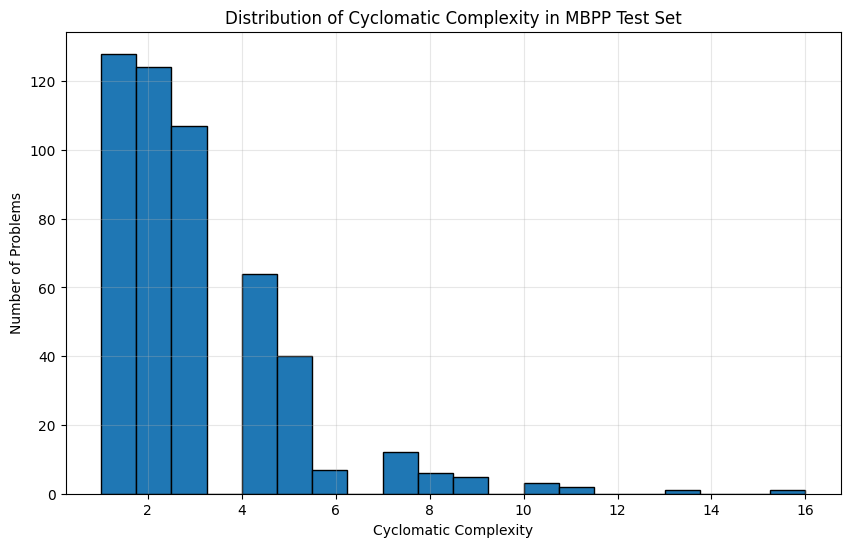


Difficulty Distribution (Cyclomatic):
  easy: 423 (84.6%)
  hard: 18 (3.6%)
  medium: 59 (11.8%)


In [15]:
# Let's analyze the cyclomatic complexity distribution across all MBPP problems
import matplotlib.pyplot as plt
import numpy as np

# Calculate cyclomatic complexity for all test problems
cyclomatic_complexities = []
cyclomatic_errors = []

for i, record in enumerate(dataset['test']):
    complexity, details = calculate_cyclomatic_complexity(record['code'])
    if complexity is not None:
        cyclomatic_complexities.append({
            'task_id': record['task_id'],
            'complexity': complexity,
            'problem': record['text'][:100]
        })
    else:
        cyclomatic_errors.append({'task_id': record['task_id'], 'error': details})

print(f"Successfully analyzed {len(cyclomatic_complexities)} problems")
print(f"Errors encountered: {len(cyclomatic_errors)}")

# Show complexity distribution
cyclomatic_values = [c['complexity'] for c in cyclomatic_complexities]
print(f"\nCyclomatic Complexity Statistics:")
print(f"  Min: {min(cyclomatic_values)}")
print(f"  Max: {max(cyclomatic_values)}")
print(f"  Mean: {np.mean(cyclomatic_values):.2f}")
print(f"  Median: {np.median(cyclomatic_values):.2f}")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(cyclomatic_values, bins=20, edgecolor='black')
plt.xlabel('Cyclomatic Complexity')
plt.ylabel('Number of Problems')
plt.title('Distribution of Cyclomatic Complexity in MBPP Test Set')
plt.grid(True, alpha=0.3)
plt.show()

# Define difficulty levels based on cyclomatic complexity
# Using standard thresholds from literature:
# 1-4: Simple, low risk
# 5-7: More complex, moderate risk
# 8-10: Complex, high risk
# 11+: Very complex, very high risk
def categorize_cyclomatic_difficulty(complexity):
    if complexity <= 4:
        return 'easy'
    elif complexity <= 7:
        return 'medium'
    else:
        return 'hard'

# Add difficulty categories
for item in cyclomatic_complexities:
    item['difficulty'] = categorize_cyclomatic_difficulty(item['complexity'])

# Show distribution by difficulty
cyclomatic_difficulty_counts = {}
for item in cyclomatic_complexities:
    diff = item['difficulty']
    cyclomatic_difficulty_counts[diff] = cyclomatic_difficulty_counts.get(diff, 0) + 1

print("\nDifficulty Distribution (Cyclomatic):")
for diff, count in sorted(cyclomatic_difficulty_counts.items()):
    percentage = (count / len(cyclomatic_complexities)) * 100
    print(f"  {diff}: {count} ({percentage:.1f}%)")